# Numerical modelling of synaptic transmission in 3D

In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from getplate import getPlate
from getCylinder import GetCylinder

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output

In [2]:
%%html 
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar {
    display: none;
} </style>

In [3]:
#Constants, for now set everything equal to one

## 3D
* Build mass matrix and load vector
* Need new mesh generator, new matrix and load vector builder, otherwise the same
* Solve system of ODE's
* More complicated animation

In [6]:
N = 100
n = 20
p, tri, bottom, middle, top = GetCylinder(N,n)

<IPython.core.display.Javascript object>


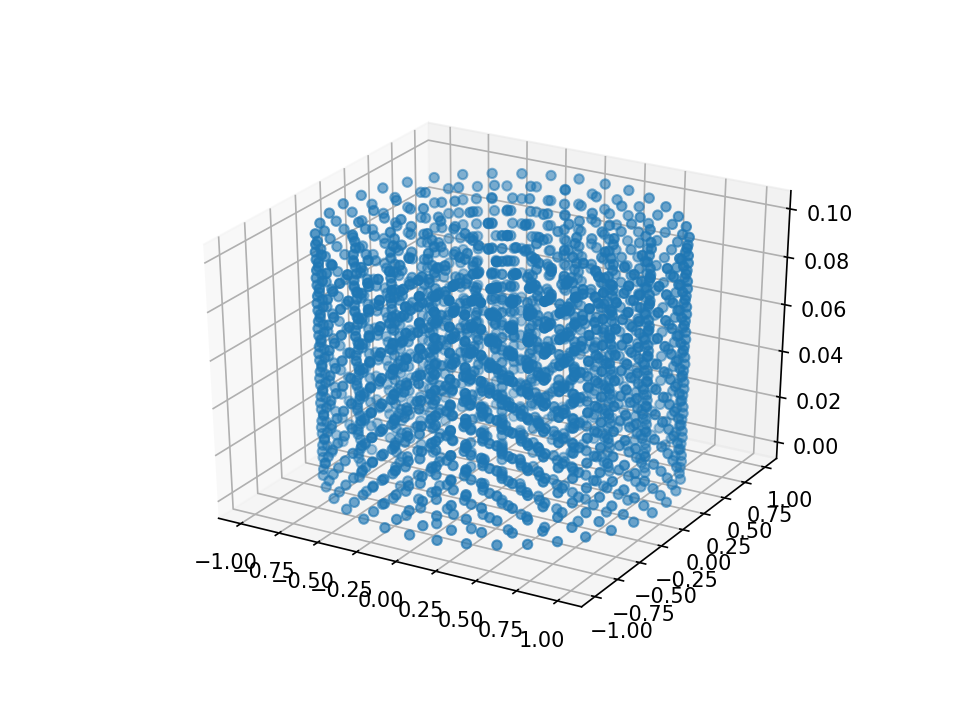

In [7]:
ax = plt.axes(projection='3d')

ax.scatter3D(p[:,0], p[:,1], p[:,2], cmap='Greens');

In [8]:
# Quadrature points and weights for gaussian integration, 27-point rule
def GaussianQuadrature3D(p1, p2, p3, p4, f):
    # map to reference
    # p1 -> 0,0,0, p2-> 1,0,0, p3-> 0,1,0, p4 -> 0,0,1
    # scale weights to volume
    #Calculate volume:
    # Reference 1/(6*np.sqrt(2))
    # Original 
    
    A = np.zeros((3,3))
    A[:,0] = p2 - p1
    A[:,1] = p3 - p1
    A[:,2] = p4 - p1
                                            
    gp = np.array([[0.112701654, 0.2123405382, 0.294997790],
                   [0.5, 0.590533135, 0.652996233],
                   [0.887298346, 0.911412040, 0.927005975]])
    
    
    gw = np.array([[0.277777778, 0.069826979, 0.029950703],
                   [0.444444444, 0.229241106, 0.146246269],
                   [0.277777778, 0.200931913, 0.157136361]])
    
    v1 = p2 - p1
    v2 = p3 - p1
    v3 = p4 - p1
    volume = 1/6 * np.abs(v1 @ np.cross(v2, v3))
    gw = gw * (volume * 6)**(1/3)
    
    I = 0
    for i in range(3):
        for j in range(3):
            for k in range(3):
                mapped = A@np.array([gp[i,2]*gp[j,1]*gp[k,0],gp[i,2]*gp[j,1]*(1-gp[k,0]),gp[i,2]*(1-gp[j,1])]) + p1
                I += gw[i,2]*gw[j,1]*gw[k,0]*f(mapped[0], mapped[1], mapped[2])
    return I

In [9]:
p1 = np.array([0,0,0])
p2 = np.array([1,0,0])
p3 = np.array([0,1,0])
p4 = np.array([0,0,1])

print(GaussianQuadrature3D(p1, p2, p3, p4, lambda x,y,z : x*y*z))

0.0013888888393469604


In [27]:
def assembleAh_k(p, elem):
    M = np.ones((4,4))
    index = np.array([elem[0], elem[1], elem[2], elem[3]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    M[:,3] = points[:,2]
    C_1 = np.linalg.solve(M, np.array([1,0,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1,0]))
    C_4 = np.linalg.solve(M, np.array([0,0,0,1]))
    C = np.array([C_1, C_2, C_3, C_4])
    
    Ah_k = np.zeros((4,4))
    Area = GaussianQuadrature3D(points[0], points[1], points[2], points[3], lambda x,y,z : 1)
    for alpha in range(4):
        for beta in range(4):
            Ah_k[alpha,beta] = Area * (C[alpha,1] * C[beta,1] + C[alpha,2] * C[beta,2] + C[alpha,3] * C[alpha,3])
    return Ah_k

def assembleAh(N, p, tri):
    Ah = np.zeros((N,N))
    for k in range(len(tri)):
        Ah_k = assembleAh_k(p, tri[k])
        for alpha in range(4):
            i = tri[k,alpha]
            for beta in range(4):
                j = tri[k,beta]
                Ah[i,j] += Ah_k[alpha, beta]
    return Ah
                      
def assembleFh_k(p, elem, f):
    M = np.ones((4,4))
    index = np.array([elem[0], elem[1], elem[2], elem[3]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    M[:,3] = points[:,2]
    C_1 = np.linalg.solve(M, np.array([1,0,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1,0]))
    C_4 = np.linalg.solve(M, np.array([0,0,0,1]))
    C = np.array([C_1, C_2, C_3, C_4])
    
    Fh_k = np.zeros(4)
    for alpha in range(4):
        H = lambda x,y,z : C[alpha,0] + C[alpha,1] * x + C[alpha,2] * y + C[alpha,3] * z
        Hf = lambda x,y,z : H(x,y,z) * f(x,y,z)
        Fh_k[alpha] = GaussianQuadrature3D(points[0], points[1], points[2], points[3], Hf)
    return Fh_k

def assembleFh(N, p, tri, f):
    Fh = np.zeros(N)
    for k in range(len(tri)):
        Fh_k = assembleFh_k(p, tri[k], f)
        for alpha in range(4):
            i = tri[k, alpha]
            Fh[i] += Fh_k[alpha]
    return Fh

def assembleMh_k(p,elem):
    M = np.ones((4,4))
    index = np.array([elem[0], elem[1], elem[2], elem[3]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    M[:,3] = points[:,2]
    C_1 = np.linalg.solve(M, np.array([1,0,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1,0]))
    C_4 = np.linalg.solve(M, np.array([0,0,0,1]))
    C = np.array([C_1, C_2, C_3, C_4])
    
    Mh_k = np.zeros((4,4))
    for alpha in range(4):
        for beta in range(4):
            Ha = lambda x,y,z: C[alpha,0] + C[alpha,1] * x + C[alpha,2] * y + C[alpha,3] * z
            Hb = lambda x,y,z: C[beta,0] + C[beta,1] * x + C[beta,2] * y + C[alpha,3] * z
            Hf = lambda x,y,z: Ha(x,y,z) * Hb(x,y,z)
            Mh_k[alpha,beta] = GaussianQuadrature3D(points[0], points[1], points[2], points[3], Hf)
    return Mh_k
    

def assembleMh(N, p, tri):
    Mh = np.zeros((N,N))
    for k in range(len(tri)):
        Mh_k = assembleMh_k(p, tri[k])
        for alpha in range(4):
            i = tri[k,alpha]
            for beta in range(4):
                j = tri[k,beta]
                Mh[i,j] += Mh_k[alpha, beta]
    return Mh

In [28]:
# A does not depend on the timestep so it can be created in the beginning.
N = 32
n = 2

p, tri, bottom, middle, top = GetCylinder(N, n)

# Assemble matrices and load vector
A = assembleAh(N*n, p, tri)
M = assembleMh(N*n, p, tri)
F = assembleFh(N*n, p, tri, lambda x,y,z : 0)

# Initial conditions
r = np.zeros(F.shape)
n = np.zeros(F.shape)
r[bottom] = np.ones(len(bottom)) * 0.01
n[top[0]] = 10

# Neumann boundary conditions in F, should be zero for the first time step
F[bottom] = - r[bottom]*n[bottom] + (1-r[bottom])
print([F[i] for i in range(len(F)) if F[i] != 0])
# Forward Euler part 

[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]


In [ ]:
N = np.array([[1.,0.42866144,0.67546234, 0.],
          [1., 0.42866144, 0.67546234, 0.00526316],
          [1., 0.38567257, 0.45962667, 0.00526316],
          [1., 0.38567257, 0.45962667, 0.]])
